In [1]:
import requests
import pandas as pd
import os
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
from dotenv import load_dotenv

# Setting pandas to display all columns and rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


# Load API key from .env file
load_dotenv('.env')
api_key = os.getenv('API_KEY')

In [2]:
def extract(api_key):
    """
    Fetch and process air quality measurements from the OpenAQ API.

    Parameters
    ----------
    api_key : str
        API key for authentication with the OpenAQ API.

    Returns
    -------
    df : pandas.DataFrame
        Dataframe containing the fetched measurements.
        
    Raises
    ------
    requests.exceptions.HTTPError
        For HTTP related errors.
    requests.exceptions.ConnectionError
        For connection related errors.
    requests.exceptions.Timeout
        For timeout errors.
    requests.exceptions.RequestException
        For all other request related errors.
    Exception
        If the fetched dataframe is empty.

    """
    
    # API URL
    api_url = "https://api.openaq.org/v2/measurements"
    
    # Define the query parameters to API
    params = {
        "location_id": "380422",
        "parameter": ["pressure", "temperature", "um003", "um025", "um010", "pm10", "um100", "pm1", "um005", "humidity", "um050", "pm25"],
        "limit": 100000,
        "api_key": api_key
    }
    
    try:
        # Make the GET request
        response = requests.get(api_url, params=params)
        
        # Raise exception for HTTP errors
        response.raise_for_status()
        
        # Check if the request was successful
        if response.status_code == 200:
            data = response.json()
            output = pd.json_normalize(data['results'])
            df = pd.DataFrame(output)
            
            # Check if dataframe is empty
            if df.empty:
                raise Exception("Empty df, check API request")
            
            df['date.utc'] = pd.to_datetime(df['date.utc'], errors='coerce') # Convert to datetime
            df['date.local'] = df['date.utc'].dt.tz_convert('America/Los_Angeles') # Covert to PST/PDT time zone
            df['date.local'] = df['date.local'].dt.tz_localize(None) # Convert to timezone-naive
            df = df[df['value'] > 0.0] # Filter values
            
            return df
        
    except requests.exceptions.HTTPError as errh:
        print("Http Error:", errh)
    except requests.exceptions.ConnectionError as errc:
        print("Error Connecting:", errc)
    except requests.exceptions.Timeout as errt:
        print("Timeout Error:", errt)
    except requests.exceptions.RequestException as err:
        print("Error: Something Else", err)
    except Exception as e:
        print(e)

In [3]:
# Call extract function
df = extract(api_key)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33404 entries, 0 to 38159
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   locationId             33404 non-null  int64              
 1   location               33404 non-null  object             
 2   parameter              33404 non-null  object             
 3   value                  33404 non-null  float64            
 4   unit                   33404 non-null  object             
 5   country                33404 non-null  object             
 6   city                   0 non-null      object             
 7   isMobile               33404 non-null  bool               
 8   isAnalysis             0 non-null      object             
 9   entity                 33404 non-null  object             
 10  sensorType             33404 non-null  object             
 11  date.utc               33404 non-null  datetime64[ns, UTC]


## Available Parameters

In [4]:
# Get locations from API

endpoint = "https://api.openaq.org/v2/parameters"

params = {
    "limit": 1000,
    "api_key": "bca2413f10b586fc8e29e6a7712258baf2d528cfdfc06dcba5bf1cc44e714a9c"
}

# API request
response = requests.get(endpoint, params=params)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    data = response.json()
    output = data['results']
    parameters = pd.DataFrame(output)
else:
    print("Error:", response.status_code)


print(parameters.info())

parameters

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             64 non-null     int64 
 1   name           64 non-null     object
 2   displayName    60 non-null     object
 3   description    64 non-null     object
 4   preferredUnit  64 non-null     object
dtypes: int64(1), object(4)
memory usage: 2.6+ KB
None


,id,name,displayName,description,preferredUnit
0,1,pm10,PM10,Particulate matter less than 10 micrometers in...,µg/m³
1,2,pm25,PM2.5,Particulate matter less than 2.5 micrometers i...,µg/m³
2,3,o3,O₃ mass,Ozone mass concentration,µg/m³
3,4,co,CO mass,Carbon Monoxide mass concentration,µg/m³
4,5,no2,NO₂ mass,Nitrogen Dioxide mass concentration,µg/m³
5,6,so2,SO₂ mass,Sulfur Dioxide mass concentration,µg/m³
6,7,no2,NO₂,Nitrogen Dioxide concentration,ppm
7,8,co,CO,Carbon Monoxide concentration,ppm
8,9,so2,SO₂,Sulfur Dioxide concentration,ppm
9,10,o3,O₃,Ozone concentration,ppm


# EDA

In [5]:
df.head(20)

,locationId,location,parameter,value,unit,country,city,isMobile,isAnalysis,entity,sensorType,date.utc,date.local,coordinates.latitude,coordinates.longitude
0,380422,Tipperary Park,um025,0.007857,particles/cm³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-13 20:00:00+00:00,2023-10-13 13:00:00,49.208733,-122.9118
1,380422,Tipperary Park,humidity,45.392857,%,CA,None,False,None,Community Organization,low-cost sensor,2023-10-13 20:00:00+00:00,2023-10-13 13:00:00,49.208733,-122.9118
2,380422,Tipperary Park,pressure,1000.648571,mb,CA,None,False,None,Community Organization,low-cost sensor,2023-10-13 20:00:00+00:00,2023-10-13 13:00:00,49.208733,-122.9118
3,380422,Tipperary Park,pm25,4.210714,µg/m³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-13 20:00:00+00:00,2023-10-13 13:00:00,49.208733,-122.9118
4,380422,Tipperary Park,um010,0.221786,particles/cm³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-13 20:00:00+00:00,2023-10-13 13:00:00,49.208733,-122.9118
5,380422,Tipperary Park,um003,7.281071,particles/cm³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-13 20:00:00+00:00,2023-10-13 13:00:00,49.208733,-122.9118
6,380422,Tipperary Park,temperature,65.607143,f,CA,None,False,None,Community Organization,low-cost sensor,2023-10-13 20:00:00+00:00,2023-10-13 13:00:00,49.208733,-122.9118
7,380422,Tipperary Park,pm1,3.128571,µg/m³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-13 20:00:00+00:00,2023-10-13 13:00:00,49.208733,-122.9118
8,380422,Tipperary Park,um005,2.045000,particles/cm³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-13 20:00:00+00:00,2023-10-13 13:00:00,49.208733,-122.9118
10,380422,Tipperary Park,pm10,4.510714,µg/m³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-13 20:00:00+00:00,2023-10-13 13:00:00,49.208733,-122.9118


In [6]:
df.columns

Index(['locationId', 'location', 'parameter', 'value', 'unit', 'country',
       'city', 'isMobile', 'isAnalysis', 'entity', 'sensorType', 'date.utc',
       'date.local', 'coordinates.latitude', 'coordinates.longitude'],
      dtype='object')

In [7]:
df.dtypes

locationId                             int64
location                              object
parameter                             object
value                                float64
unit                                  object
country                               object
city                                  object
isMobile                                bool
isAnalysis                            object
entity                                object
sensorType                            object
date.utc                 datetime64[ns, UTC]
date.local                    datetime64[ns]
coordinates.latitude                 float64
coordinates.longitude                float64
dtype: object

In [10]:
df['parameter'].unique()

array(['um025', 'humidity', 'pressure', 'pm25', 'um010', 'um003',
       'temperature', 'pm1', 'um005', 'pm10', 'um050', 'um100'],
      dtype=object)

In [11]:
df[df["parameter"] == "pm25"].size

60120

In [12]:
df[df["parameter"] == "pm25"].head()

,locationId,location,parameter,value,unit,country,city,isMobile,isAnalysis,entity,sensorType,date.utc,date.local,coordinates.latitude,coordinates.longitude
3,380422,Tipperary Park,pm25,4.210714,µg/m³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-13 20:00:00+00:00,2023-10-13 13:00:00,49.208733,-122.9118
20,380422,Tipperary Park,pm25,6.418519,µg/m³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-13 19:00:00+00:00,2023-10-13 12:00:00,49.208733,-122.9118
28,380422,Tipperary Park,pm25,5.272000,µg/m³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-13 18:00:00+00:00,2023-10-13 11:00:00,49.208733,-122.9118
39,380422,Tipperary Park,pm25,16.054167,µg/m³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-13 17:00:00+00:00,2023-10-13 10:00:00,49.208733,-122.9118
56,380422,Tipperary Park,pm25,6.303704,µg/m³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-13 16:00:00+00:00,2023-10-13 09:00:00,49.208733,-122.9118


In [13]:
df['value'][df["parameter"] == "pm25"].head()

3      4.210714
20     6.418519
28     5.272000
39    16.054167
56     6.303704
Name: value, dtype: float64

In [14]:
df['value'][df["parameter"] == "pm25"].describe()

count    4008.000000
mean        9.540195
std        10.394948
min         0.014286
25%         2.797917
50%         6.089524
75%        11.915172
max       116.162069
Name: value, dtype: float64

In [15]:
for par in df['parameter'].unique():
    result = df['value'][df["parameter"] == par].describe()
    nan_values = df['value'][df["parameter"] == par].isna().sum()
    print(par, end='\n')
    print (result)
    print('Number of nan values:', nan_values)
    print('\n')

um025
count    3633.000000
mean        0.040521
std         0.066029
min         0.000333
25%         0.008333
50%         0.020000
75%         0.043333
max         0.900345
Name: value, dtype: float64
Number of nan values: 0


humidity
count    2352.000000
mean       49.036598
std        12.813569
min        16.857143
25%        39.000000
50%        49.603147
75%        60.000000
max        81.739130
Name: value, dtype: float64
Number of nan values: 0


pressure
count    2352.000000
mean     1007.425978
std         4.576911
min       988.509000
25%      1005.080865
50%      1007.925815
75%      1010.062614
max      1021.713000
Name: value, dtype: float64
Number of nan values: 0


pm25
count    4008.000000
mean        9.540195
std        10.394948
min         0.014286
25%         2.797917
50%         6.089524
75%        11.915172
max       116.162069
Name: value, dtype: float64
Number of nan values: 0


um010
count    4008.000000
mean        0.610267
std         0.834184
min         0.

c:\Users\Ale\anaconda3\envs\automate-etl\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\Ale\anaconda3\envs\automate-etl\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\Ale\anaconda3\envs\automate-etl\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\Ale\anaconda3\envs\automate-etl\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\Ale\anaconda3\envs\automate-etl\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\Ale\anaconda3\envs\automate-etl\lib\site-packages\seaborn\axisgrid.py:118: UserWarning

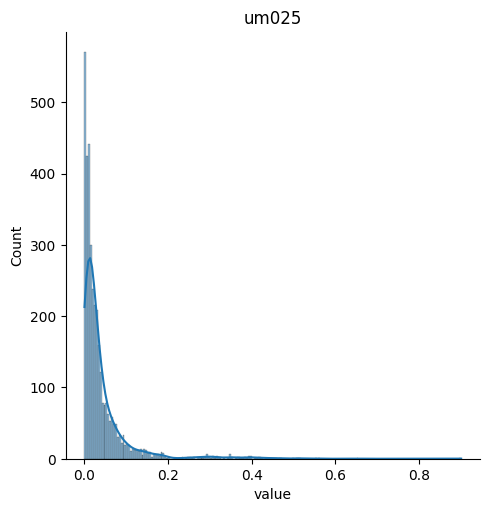

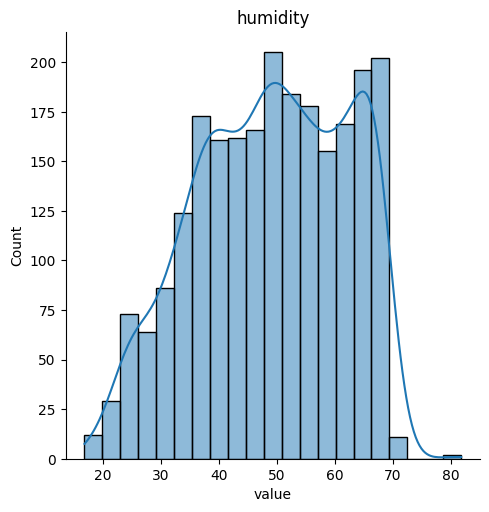

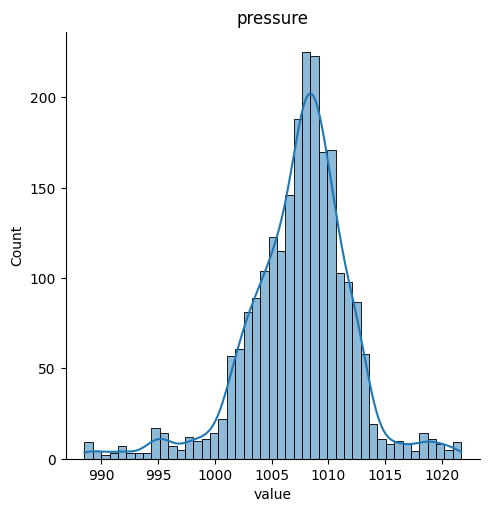

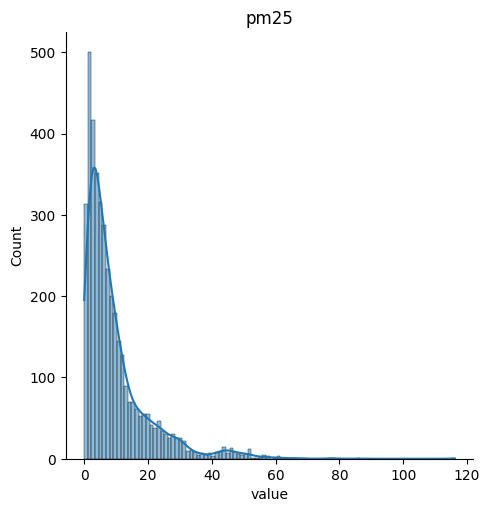

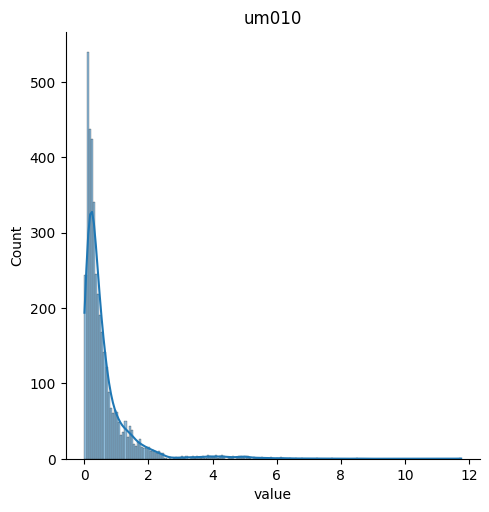

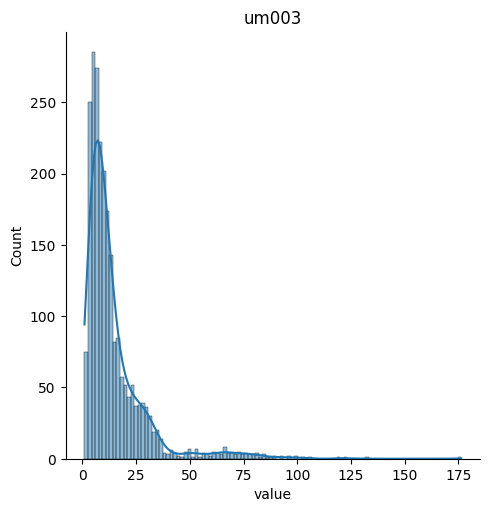

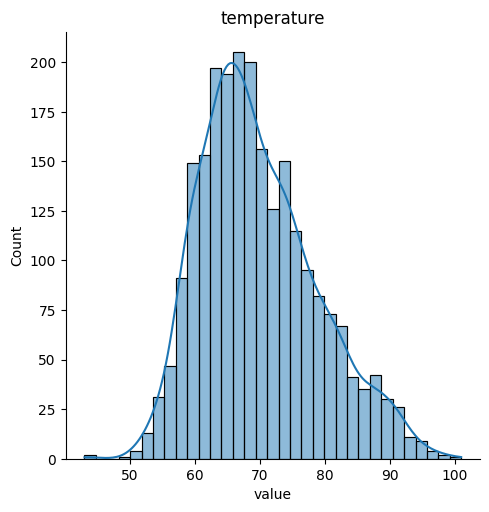

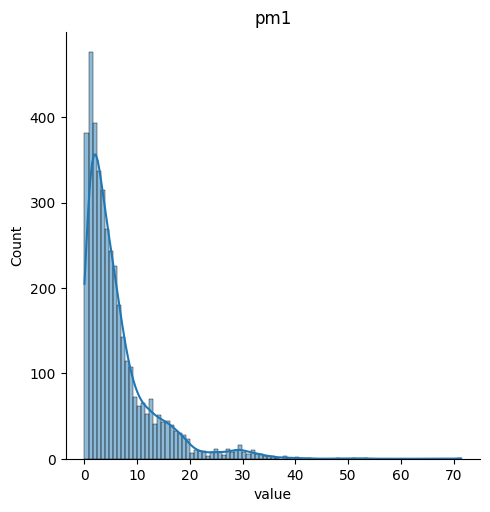

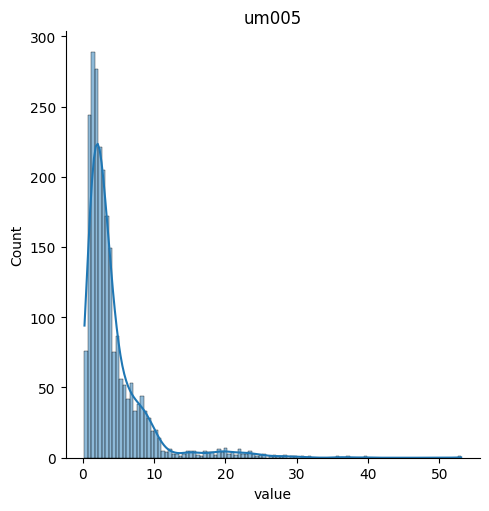

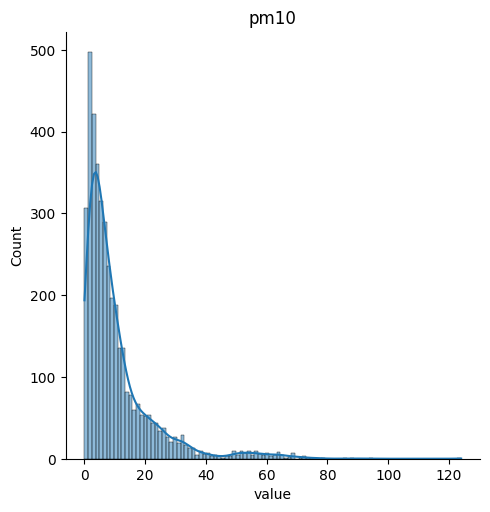

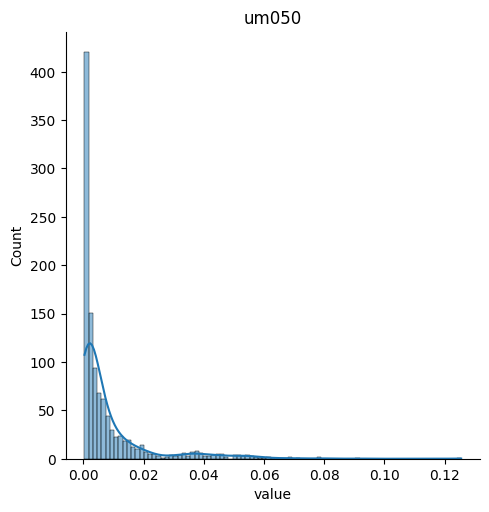

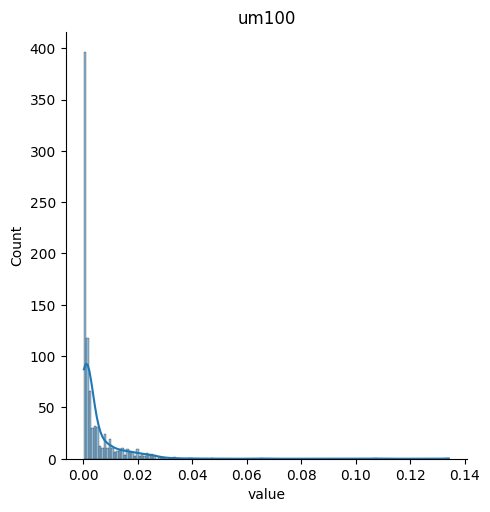

In [16]:
for par in df['parameter'].unique():
    sns.displot(df['value'][df["parameter"] == par], kde=True).set(title=par)

In [17]:
print(df['date.local'].min())
print(df['date.local'].max())

2022-11-20 17:00:00
2023-10-13 13:00:00


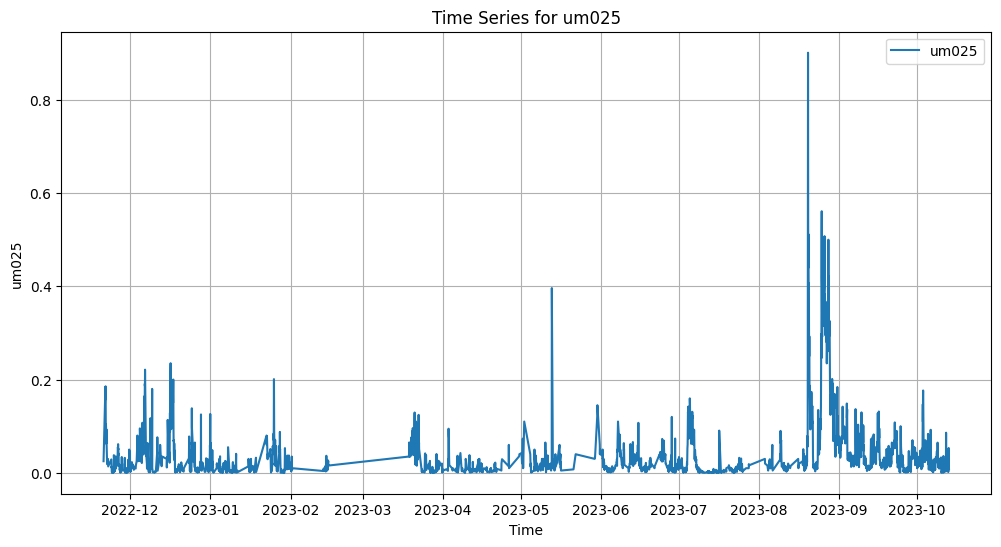

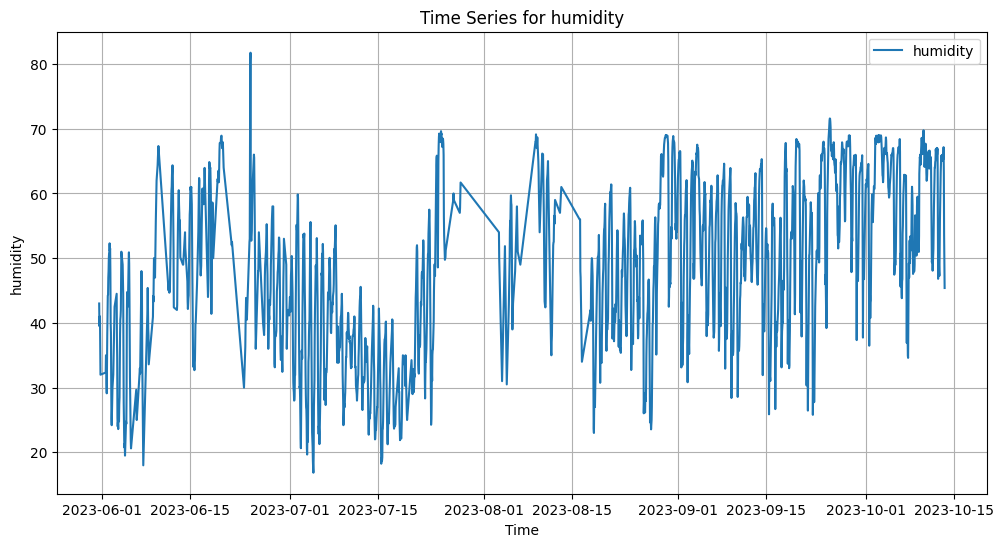

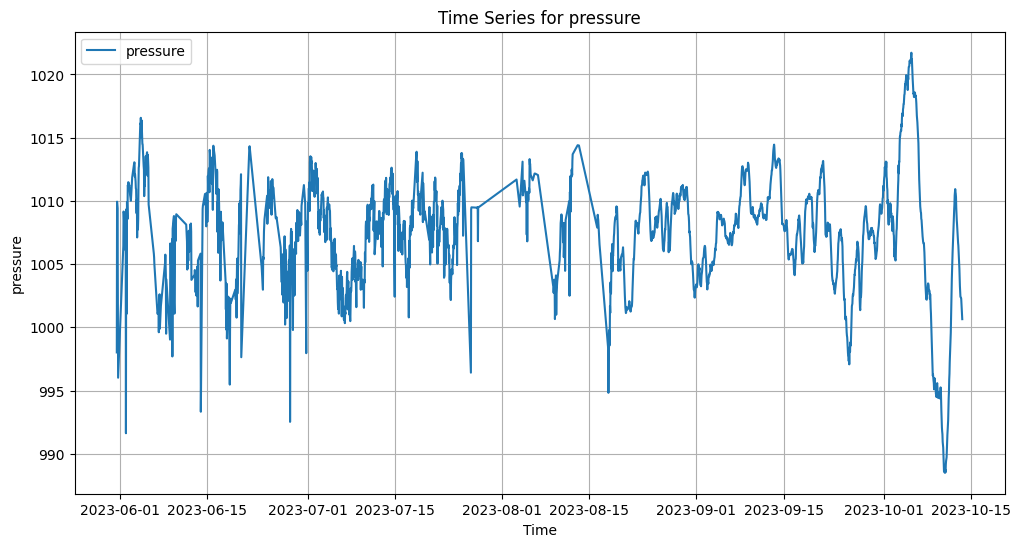

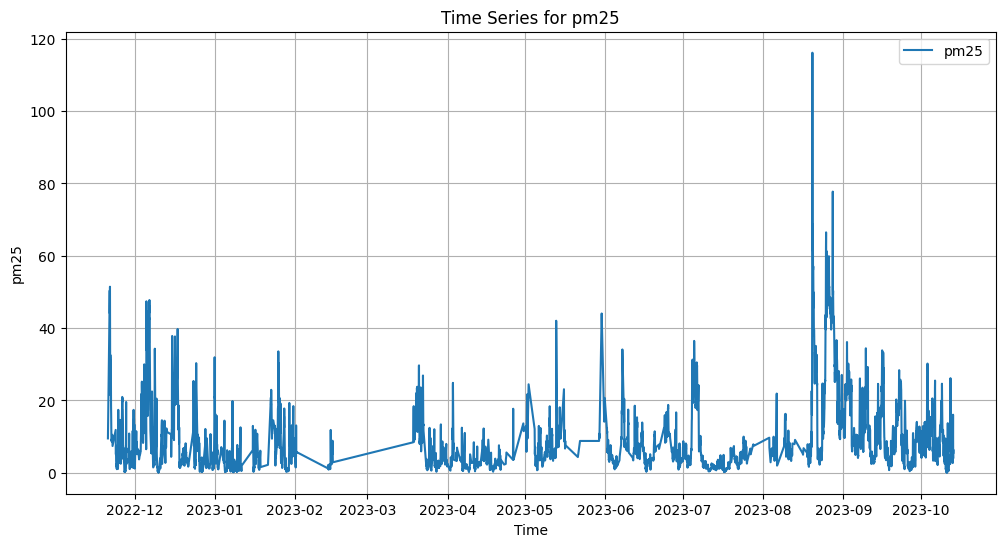

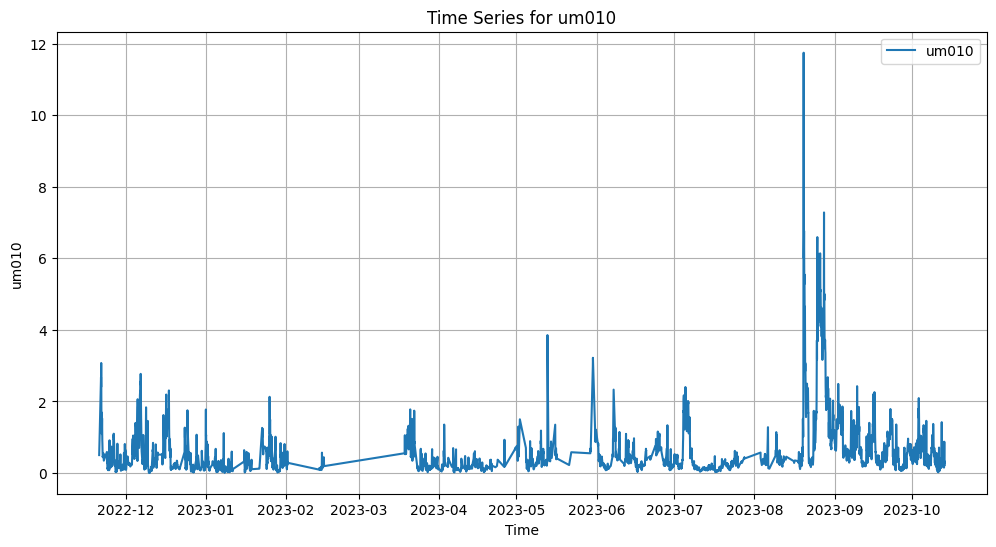

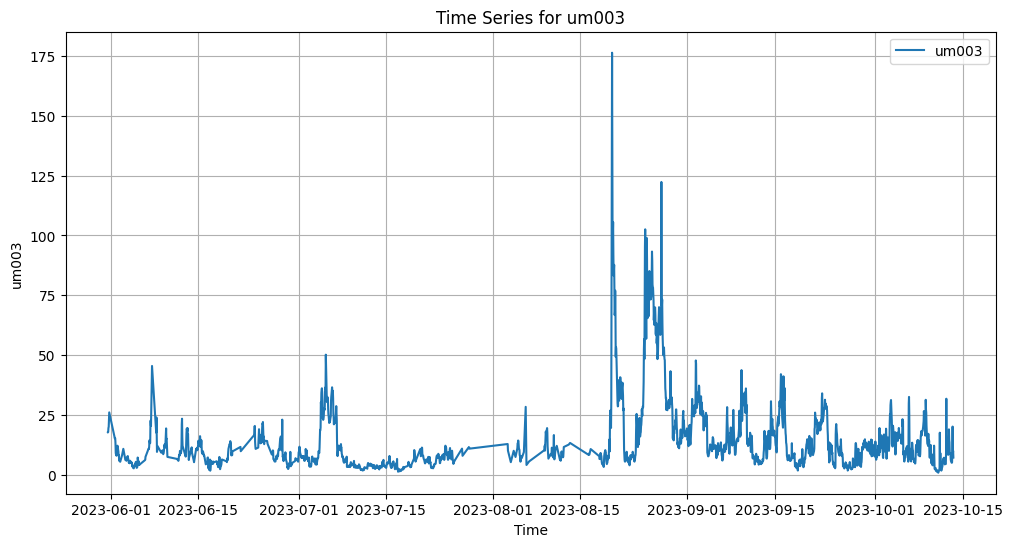

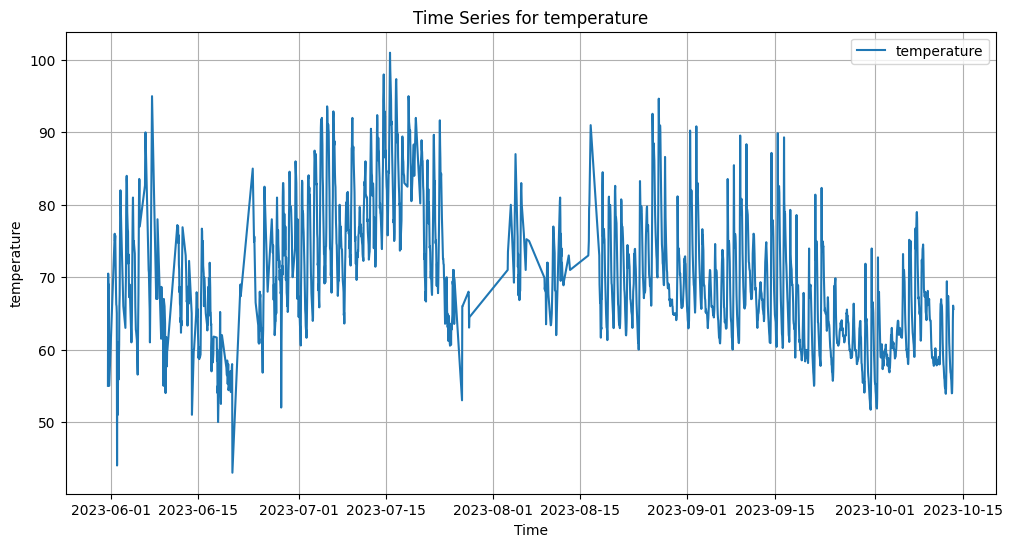

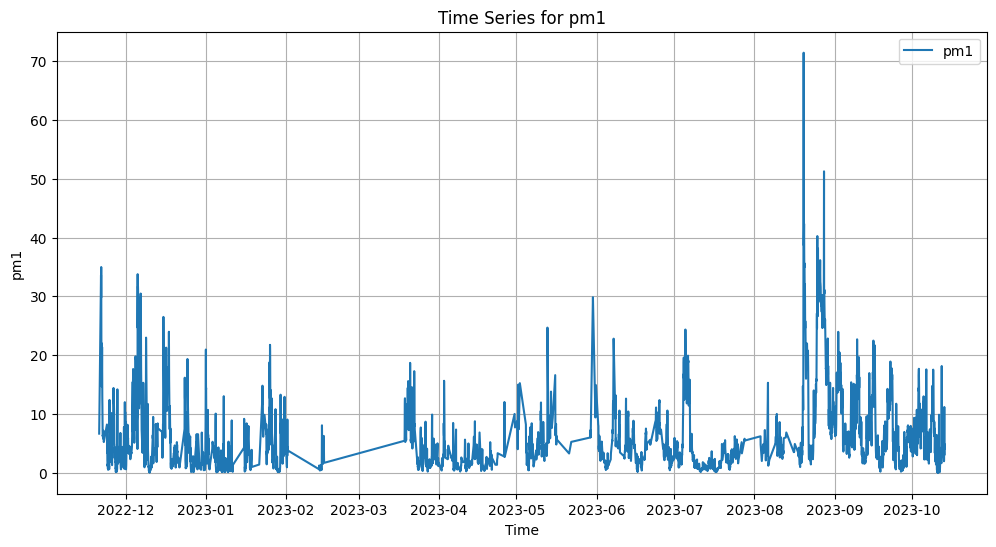

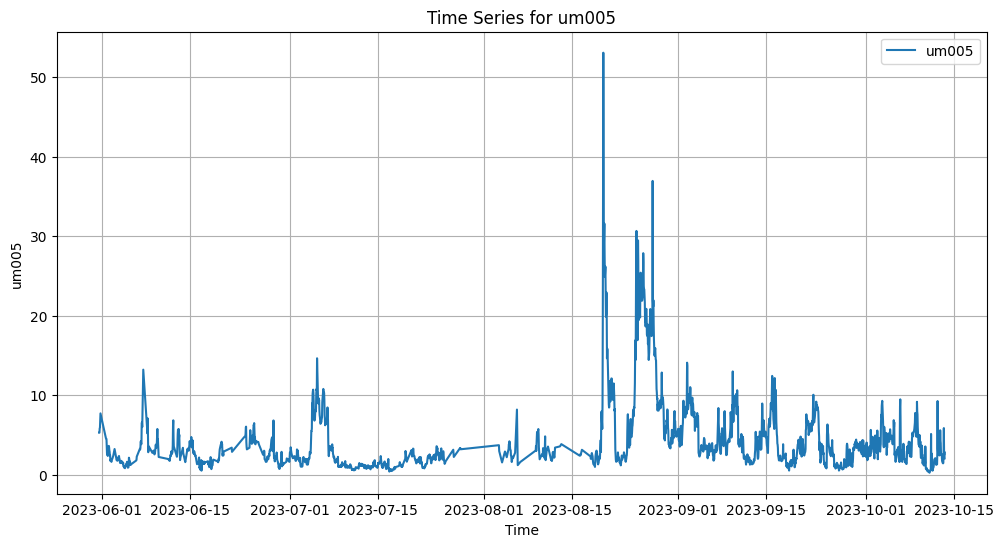

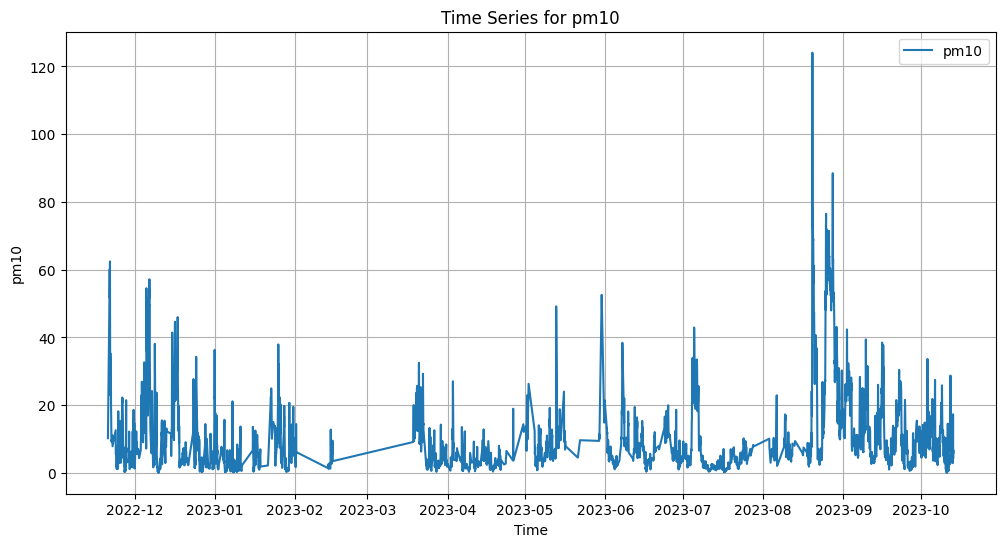

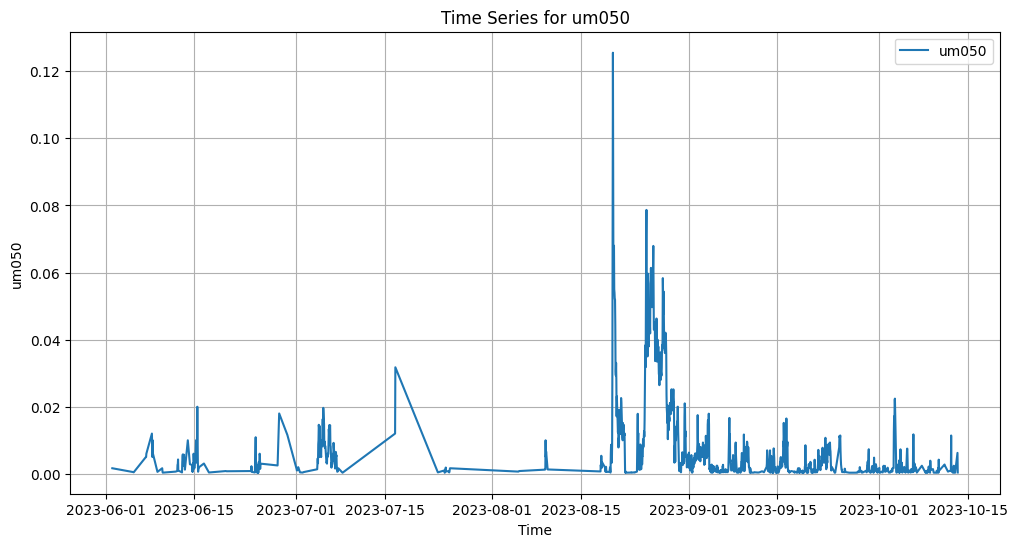

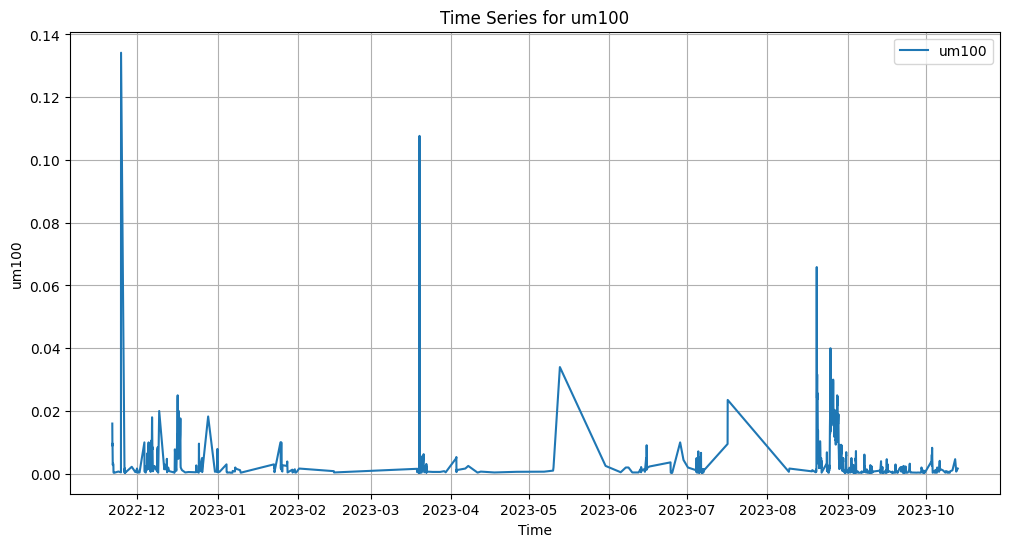

In [18]:
# Loop through unique parameters
for par in df['parameter'].unique():
    plt.figure(figsize=(12, 6))
    
    # Filter the DataFrame for the current parameter
    subset = df[df['parameter'] == par]
    
    # Create the plot
    plt.plot(subset['date.local'], subset['value'], label=par)
    
    plt.xlabel('Time')
    plt.ylabel(par)
    plt.grid(True)
    plt.legend()
    plt.title(f"Time Series for {par}")
    plt.show()

In [19]:
#for parameter in df['parameter'].unique():
#    locals()[parameter] = df[df["parameter"] == parameter]
    
#pm25.head()

In [20]:
pivoted_df = df.pivot_table(index=df['date.local'], columns='parameter', values='value')
pivoted_df.head(20)

parameter,humidity,pm1,pm10,pm25,pressure,temperature,um003,um005,um010,um025,um050,um100
date.local,,,,,,,,,,,,
2022-11-20 17:00:00,NaN,6.650000,10.250000,9.500000,NaN,NaN,NaN,NaN,0.500000,0.025000,NaN,NaN
2022-11-21 10:00:00,NaN,33.600000,60.220000,50.420000,NaN,NaN,NaN,NaN,2.678000,0.184000,NaN,0.016000
2022-11-21 11:00:00,NaN,29.728571,51.614286,44.053571,NaN,NaN,NaN,NaN,2.401786,0.157500,NaN,0.008929
2022-11-21 12:00:00,NaN,34.979310,62.441379,51.451724,NaN,NaN,NaN,NaN,3.074483,0.185517,NaN,0.009655
2022-11-21 13:00:00,NaN,28.222222,48.892593,41.762963,NaN,NaN,NaN,NaN,2.449630,0.154444,NaN,0.009630
2022-11-21 14:00:00,NaN,18.152174,28.652174,26.921739,NaN,NaN,NaN,NaN,1.408261,0.087391,NaN,0.003478
2022-11-21 15:00:00,NaN,22.044828,35.382759,32.610345,NaN,NaN,NaN,NaN,1.694138,0.103793,NaN,0.002759
2022-11-21 16:00:00,NaN,21.570000,34.316667,31.843333,NaN,NaN,NaN,NaN,1.615333,0.100333,NaN,0.003333
2022-11-21 17:00:00,NaN,21.300000,33.803704,31.318519,NaN,NaN,NaN,NaN,1.594444,0.100000,NaN,0.003333


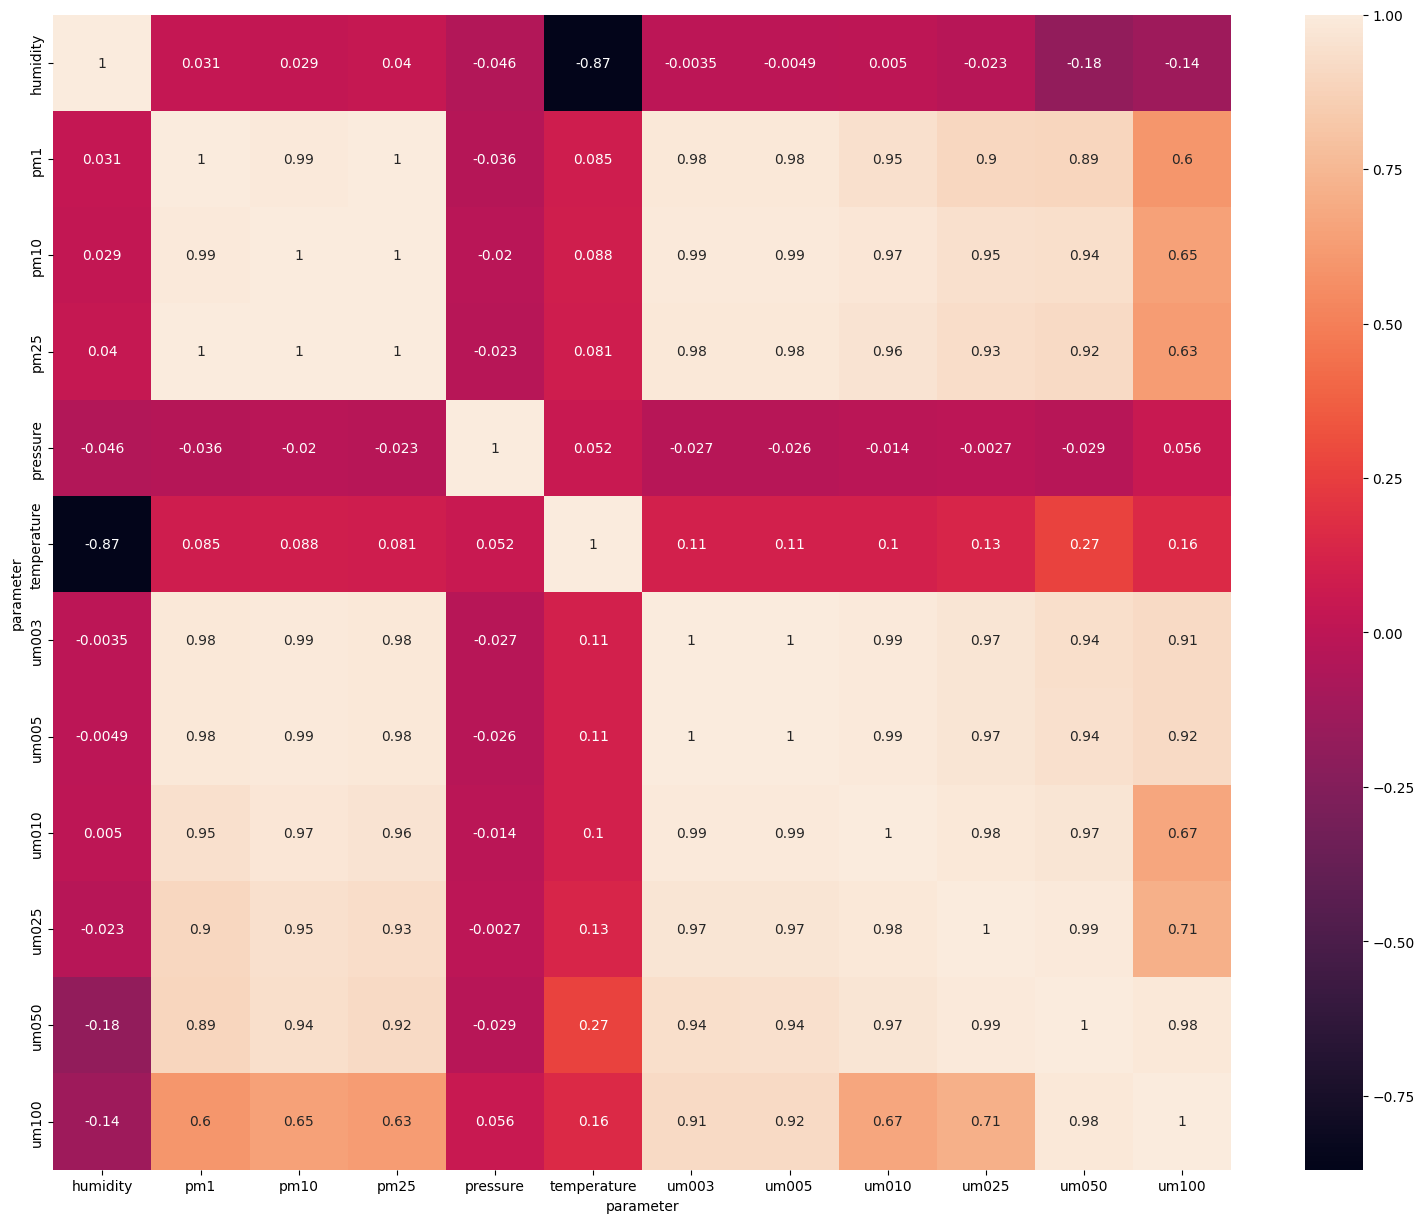

In [21]:
corr_matrix = pivoted_df.corr()
plt.figure(figsize=(19, 15))
sns.heatmap(corr_matrix, annot=True)
plt.show()